# PROJECT: Course Optimization for Data Science 2022-2023
## Optimization strategies for the "smoothed" quantile regression with (non-)smooth penalties

Author: Alexandre Gramfort

If you have questions or if something is not clear in the text below please contact us
by email.

## Aim:

- Derive mathematically and implement the loss and gradient of a smoothed pinball loss used for quantile regression
- Implement your own solvers for L1 and L2 regularizations with: (Accelerated) Proximal gradient descent, proximal coordinate descent and L-BFGS (only for L2)
- Implement your own scikit-learn estimator for L1 or L2 regularized smoothed-quantile regression model and test it on a real dataset where we will look at prediction invtervals.


## VERY IMPORTANT

This work must be done by pairs of students.
Each student must send their work before the 2nd of January 2023 at 23:59, using the moodle platform.
This means that **each student in the pair sends the same file**

On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called "Project".
This is where you submit your jupyter notebook file.

The name of the file must be constructed as in the next cell

### Gentle reminder: no evaluation if you don't respect this EXACTLY

#### How to construct the name of your file

In [35]:
# Change here using YOUR first and last names
fn1 = "maruis_bartel"
ln1 = "samo_kamga"
fn2 = "zakaria"
ln2 = "tozy"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["project", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

project_samo_kamga_maruis_bartel_and_tozy_zakaria.ipynb


Some imports

In [36]:
%matplotlib inline
import numpy as np
from scipy import linalg
import time
import matplotlib.pyplot as plt

## Part 1: Smoothed quantile regression model

[Quantile regression](https://en.wikipedia.org/wiki/Quantile_regression) is a supervised learning regression model with target space $\mathcal{Y} = \mathbb{R}$. It is a method widely used in statistics to obtain prediction intervals, and it is very often used in time series forecasting.

We consider observations $x \in \mathbb{R}^{P}$. $P$ is the number of features, and we will denote the $N$ observations available in the training set as $x_1, \dots, x_N$.

We consider a linear model, _i.e.,_ we want to learn the parameters $\theta = (w, b) \in \mathbb{R}^{P}\times \mathbb{R}$ such that the value of $w^\top x + b$ is the $\tau$-quantile of the conditional distribution $y | x$. For example, for $\tau=0.5$, we want to learn the parameters such that the value of $w^\top x + b$ is the *median* of the conditional distribution $y | x$. For $\tau=0.9$, we want to learn the parameters such that the value of $w^\top x + b$ is the *90th percentile* of the conditional distribution $y | x$, meaning that 90% of the observations of $y | x$ are below $w^\top x + b$.

An estimate $\hat{q}$ of the $\tau$-conditional sample quantile is obtained by minimizing the following loss function:
$$
\hat{q} = \arg\min_{q}
    \frac{1}{N} \sum_{i=1}^N
    \left[
            (\tau - 1) \mathbb{1}_{\{y_i < q\}} (y_i - q) + 
            \tau \mathbb{1}_{\{y_i \geq q\}} (y_i - q)
    \right]
$$

The function $\ell_\tau(z) = (\tau - 1) \mathbb{1}_{\{z \leq 0\}} (z) + \tau \mathbb{1}_{\{z \geq 0\}} (z)$ is known as the **pinball loss**. The above loss can then be rewritten as:
$$
\hat{q} = \arg\min_{q}
    \frac{1}{N} \sum_{i=1}^N \ell_\tau(y_i - q) \enspace.
$$
The optimization problem becomes:
$$
\hat{w}, \hat{b} = \arg\min_{w, b} L(w, b)
    \enspace \mathrm{with} \enspace L(w, b) = \frac{1}{N} \sum_{i=1}^N \ell_\tau(y_i - w^\top x_i - b)
$$

Introducing some regularization on the parameter $w$ with parameter $\lambda \ge 0$, the penalized estimation problem is written:

$$
    (\mathcal{P}^{\mathcal{R}}):
	\min_{w \in \mathbb{R}^P, b \in \mathbb{R}} \quad L(w, b) + \lambda \mathcal{R}(w)
$$

where $\mathcal{R}(w)$ can be :
- $\mathcal{R}_1(w) = \|w\|_1 = \sum_{j=1}^P |w_{j}|$, ie. an $\ell_1$ norm
- $\mathcal{R}_2(w) = \|w\|_2^2 = \sum_{j=1}^P w_{j}^2$, ie. a squared $\ell_2$ norm

Here is an implementation of the pinball loss:

In [37]:
def pinball(z, tau=0.5):
    """Compute the pinball loss for z and a quantile tau.

    Parameters
    ----------
    z : ndarray, shape (n_samples,)
        The values on which to compute the pinball loss.
    tau : float in [0, 1]
        The quantile.
    
    Returns
    -------
    loss : ndarray, shape (n_samples,)
        The value of the pinball loss for each value of z.
    """
    sign = (z >= 0).astype(z.dtype)
    loss = tau * sign * z - (1 - tau) * (1 - sign) * z
    return loss

#### QUESTION 0

- Plot the pinball loss for tau=0.3, 0.5 and 0.7.

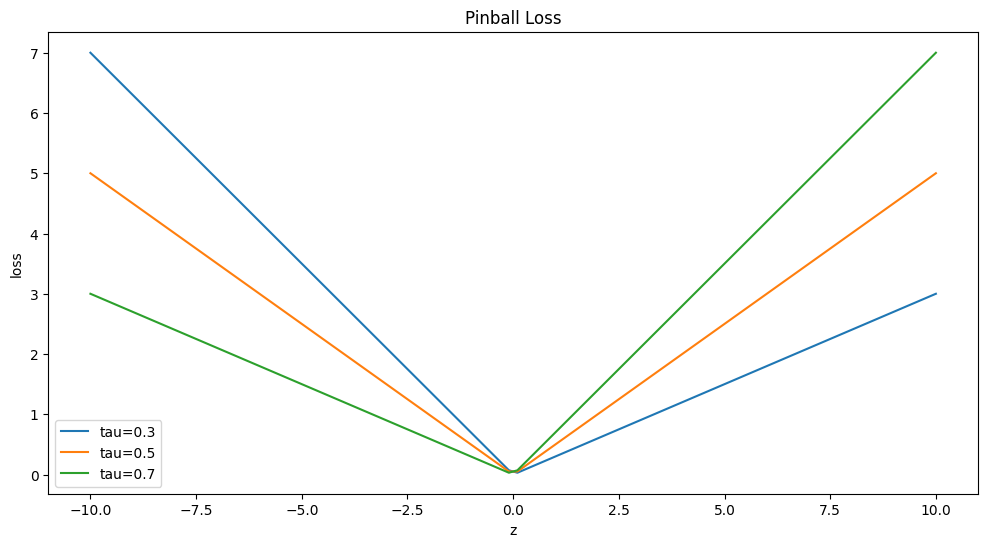

In [38]:
# Create an array of values for z ranging from -10 to 10 with 100 points
z = np.linspace(-10,10, 100)

# Calculate pinball loss for three different quantile values (tau)
pb1 = pinball(z, 0.3)
pb2 = pinball(z, 0.5)
pb3 = pinball(z, 0.7)

# Set up a figure
plt.figure(figsize=(12,6))

# Plot pinball loss as a function of z for each tau value
plt.plot(z, pb1, label="tau=0.3")
plt.plot(z, pb2, label="tau=0.5")
plt.plot(z, pb3, label="tau=0.7")

# Add axis labels and a plot title
plt.xlabel("z")
plt.ylabel("loss")
plt.title("Pinball Loss")

# Add a legend to the plot
plt.legend()

# Display the plot
plt.show()

#### QUESTION 1:

- Justify that $(\mathcal{P}^{\mathcal{R}_1})$ and $(\mathcal{P}^{\mathcal{R}_2})$ are convex optimization problems.
- Can you readily apply gradient descent or proximal gradient descent to solve these two problems?
- You will justify your answer by commenting on the smoothness of the objective functions.

INSERT YOUR ANSWER HERE

Let us illustrate what type of solution one obtains when minimizing the pinball loss. For now, we will use a black-box optimization method from `scipy`.

-0.002400473644304948 8.79287859196373
0.5041380167639535 9.82171577874099
0.9469404366032285 10.872811111721525


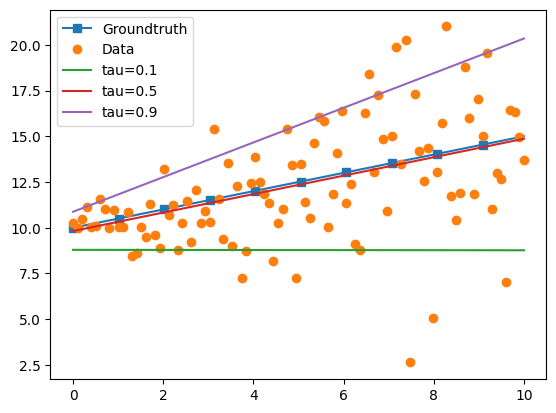

In [39]:
import numpy as np
from scipy.optimize import minimize

rng = np.random.RandomState(42)
x = np.linspace(start=0, stop=10, num=100)
X = x[:, np.newaxis]  # make X two-dimensional with one column
y_true = 10 + 0.5 * x
y = y_true + rng.normal(loc=0, scale=0.5 + 0.5 * x, size=x.shape[0])

plt.plot(x, y_true, "s-", label='Groundtruth', markevery=10)
plt.plot(x, y, 'o', label="Data")
tau = 0.3

def pobj(wb, tau):
    w, b = wb[:1], wb[-1]
    return np.mean(pinball(y - X @ w - b, tau=tau))

for tau in [0.1, 0.5, 0.9]:
    w_hat, b_hat = minimize(lambda wb : pobj(wb, tau), x0=[0, 0]).x
    print(w_hat, b_hat)
    plt.plot(x, x * w_hat + b_hat, label=f"tau={tau}")

plt.legend()

One can observe that the predictions obtained with 0.1 and 0.9 form an interval that can be used to evaluate the uncertainty of the prediction.

## Smoothed pinball loss

Let us define the function:

$$
    \ell_\tau^\delta(z) = \min_{u \in \mathbb{R}} \quad
    \underbrace{
        \ell_\tau(u) + \tfrac{1}{2\delta} (z - u)^2
    }_{J(u)}
$$

#### QUESTION 2:
- Justify that the function $\ell_\tau^\delta: z \rightarrow \ell_\tau^\delta(z)$ is well defined, meaning that a unique function value exists for each value of z.
- Prove that for any $\delta >0$, we have $\ell_\tau^\delta(z) \leq \ell_\tau(z)$.
- Prove that the function $\ell_\tau^\delta$ is given by the formula just below:

$$
    \ell_\tau^\delta (z) = \left\{
	\begin{aligned}
	\tau (z - \frac{\delta \tau}{2}) & \quad \mathrm{ if } \quad  \delta \tau \leq z \\
	\frac{z^2}{2 \delta} & \quad \mathrm{ if } \quad 0 \leq z < \tau \delta \\
	\frac{z^2}{2 \delta} & \quad \mathrm{ if } \quad  -\delta (1 - \tau) \leq z < 0 \\
    (1-\tau) \left( -z - \tfrac{\delta}{2} (1 - \tau) \right) & \quad \mathrm{ otherwise }
	\end{aligned}
    \right.
$$


The function $\ell_\tau^\delta: z \rightarrow \ell_\tau^\delta(z)$ is well defined because the minimization problem:

$$
\min_{u \in \mathbb{R}} \quad J(u) = \ell_\tau(u) + \tfrac{1}{2\delta} (z - u)^2
$$

has a unique solution. This can be seen by noting that the function $J(u)$ is strictly convex, which means that it has a unique minimum.



To prove that $\ell_\tau^\delta(z) \leq \ell_\tau(z)$ for all $z \in \mathbb{R}$ and all $\delta > 0$, we will use the definition of the smoothed pinball loss as the minimum of $J(u) = \ell_\tau(u) + \frac{1}{2\delta} (z - u)^2$ over all $u \in \mathbb{R}$:

$$\ell_\tau^\delta(z) = \min_{u \in \mathbb{R}} J(u)$$

Since $J(u) \geq \ell_\tau(u)$ for all $u \in \mathbb{R}$, we have:

$$\ell_\tau^\delta(z) = \min_{u \in \mathbb{R}} J(u) \leq \min_{u \in \mathbb{R}} \ell_\tau(u) = \ell_\tau(z)$$

Therefore, $\ell_\tau^\delta(z) \leq \ell_\tau(z)$ for all $z \in \mathbb{R}$ and all $\delta > 0$.

PAS DE REPONSE POUR LA 3 EME QUESTION

#### QUESTION 3:
- Implement the function `smooth_pinball(z, tau, delta)` that applies $\ell_\tau^\delta$ to each entry a numpy array. You will plot the function `smooth_pinball` and `pinball` between -2 and 2.

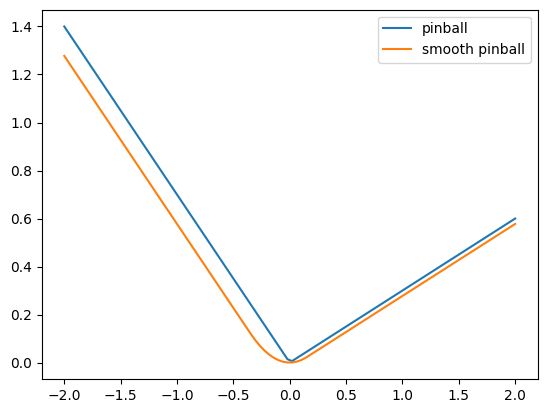

In [40]:
def smooth_pinball(z, tau, delta):
    """Compute the smoothed pinball loss
    
    Parameters
    ----------
    z : array-like, shape (n_samples,)
        The array on which to compute the smoothed pinball loss.
    tau : float in [0, 1]
        The quantile.
    delta : float
        The smoothing parameter.
    
    Returns
    -------
    l : array-like, shape (n_samples,)
        The smoothed pinball loss values.
    """
    out = z.copy().astype(np.float64)
    
    ### TODO
    # Calculate the smoothed pinball loss for different ranges of z
    out[z >= delta * tau] = tau * (z[z >= delta * tau] - (delta * tau / 2))
    out[(z>=0) & (z < tau * delta)] = (z[(z>=0) & (z < tau * delta)]**2) / ( 2 * delta)
    out[(z>= -delta*(1-tau)) & (z<0)] = (z[(z>= -delta*(1-tau)) & (z<0)]**2) / ( 2 * delta)
    out[z < -delta*(1-tau)] = (1 - tau) * (-z[z < -delta*(1-tau)] - (delta * (1-tau))/2)
    ### END TODO
    return out

x = np.linspace(-2, 2, 100)
tau = 0.3

### TODO plotting
# Plot the pinball loss and the smoothed pinball loss as a function of x
plt.figure()
plt.plot(x, pinball(x, tau), label = "pinball")
plt.plot(x, smooth_pinball(x, tau, 0.5), label = "smooth pinball")
plt.legend()
plt.show()
### END TODO

#### QUESTION 4:
- What is the derivative of the smoothed pinball loss $\ell_\tau^\delta$?
- Justify that the derivative of the smoothed pinball loss is continuous.
- Justify that the function $\ell_\tau^\delta$ is L-smooth. Propose a value for the Lipschitz constant of its gradient.
- Justify that the function $\ell_\tau^\delta$ is convex. Is it strongly convex?
- Implement the function `grad_smooth_pinball(z, tau, delta)` that applies the derivative of $\ell_\tau^\delta$ to each entry of a numpy array.

**Remark:** You will use the `scipy.optimize.check_grad` function to assess the validity of your result. You will need to test your gradient in both the linear and quadratic regions of the function (not just in one location).

The derivative of the smoothed pinball loss is given by:

$$\frac{d\ell_\tau^\delta}{dz} =
\begin{cases}
\frac{z}{\delta} & \text{if } 0 \leq z < \delta\tau \\
\tau & \text{if } z \geq \delta\tau \\
\frac{z}{\delta} & \text{if } -\delta(1-\tau) \leq z < 0 \\
\tau - 1 & \text{if } z < -\delta(1-\tau)
\end{cases}$$

This is derived by considering the different ranges of the input $z$ and applying the definition of the smoothed pinball loss:

$$\ell_\tau^\delta(z) =
\begin{cases}
\frac{z^2}{2\delta} & \text{if } 0 \leq z < \delta\tau \\
\tau z - \frac{\delta\tau}{2} & \text{if } z \geq \delta\tau \\
\frac{z^2}{2\delta} & \text{if } -\delta(1-\tau) \leq z < 0 \\
-(1-\tau)z - \frac{\delta(1-\tau)}{2} & \text{if } z < -\delta(1-\tau)
\end{cases}$$

The derivative of the smoothed pinball loss is continuous because it is a piecewise linear function. A piecewise linear function is continuous because it consists of a finite number of linear functions, which are continuous.

The function $\ell_\tau^\delta(z)$ is L-smooth because it is a piecewise quadratic function, and the derivative of a quadratic function is linear. Therefore, the Lipschitz constant of the gradient of $\ell_\tau^\delta(z)$ is equal to the maximum of $\tau$ and $1-\tau$. This value is always greater than or equal to 1, so the function $\ell_\tau^\delta(z)$ is L-smooth with Lipschitz constant greater than or equal to 1.

The function $\ell_\tau^\delta(z)$ is convex because it is a piecewise quadratic function, and a quadratic function is convex. However, the function $\ell_\tau^\delta(z)$ is not strongly convex because the Lipschitz constant of its gradient is not strictly greater than 1. Strong convexity requires the Lipschitz constant of the gradient to be strictly greater than 1.

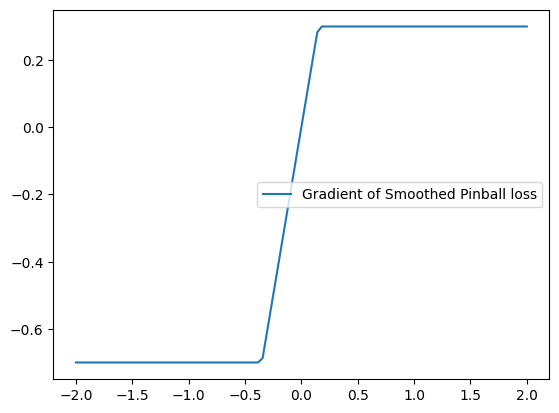

In [41]:
def grad_smooth_pinball(z, tau, delta):
    """Compute the derivative of the smoothed pinball loss
    
    Parameters
    ----------
    z : array-like, shape (n_samples,)
        The array on which to compute the smoothed pinball loss.
    tau : float in [0, 1]
        The quantile.
    delta : float
        The smoothing parameter.
    
    Returns
    -------
    dl : array-like, shape (n_samples,)
        The derivative of smoothed pinball loss computed element-wise.
    """
    out = z.copy().astype(np.float64)
    
    ### TODO
    # Calculate the derivative of the smoothed pinball loss for different ranges of z
    out[z >= delta * tau] = tau 
    out[(z>=0) & (z < tau * delta)] = z[(z>=0) & (z < tau * delta)] / delta
    out[(z>= -delta*(1-tau)) & (z<0)] = z[(z>= -delta*(1-tau)) & (z<0)] / delta
    out[z < -delta*(1-tau)] = tau - 1
    ### END TODO
    return out


# Create an array of values for x ranging from -2 to 2 with 100 points
x = np.linspace(-2, 2, 100)

# Set the quantile value
tau = 0.3

# Plot the derivative of the smoothed pinball loss as a function of x
plt.plot(x, grad_smooth_pinball(x, tau=tau, delta=.5), label='Gradient of Smoothed Pinball loss')

# Add a legend to the plot
plt.legend()

In [42]:
from scipy.optimize import check_grad

### TODO check gradient with check_grad function.
print(check_grad(smooth_pinball, grad_smooth_pinball, np.array([-1.]), 0.3, 0.5))
print(check_grad(smooth_pinball, grad_smooth_pinball, np.array([0.]), 0.3, 0.5))
print(check_grad(smooth_pinball, grad_smooth_pinball, np.array([0.15]), 0.3, 0.5))
### END TODO

4.470348313745376e-09
1.4901161193847656e-08
4.656613983300417e-11


From now on, we consider the following optimization problem:

$$
    (\mathcal{P}_\delta^\mathcal{R}): \min_{w, b} \quad L_\delta(w, b) + \lambda \mathcal{R}(w)
$$

where $\mathcal{R}(w)$ can be $\mathcal{R}_1(w)$ or $\mathcal{R}_2(w)$, and where $L_\delta(w, b) = \frac{1}{N} \sum_{i=1}^N \ell_\tau^\delta(y_i - w^\top x_i - b)$.

#### QUESTION 5:
- Justify what optimization strategy among L-BFGS, (proximal-)gradient descent, (proximal-)coordinate descent is readily applicable
  for $(\mathcal{P}_\delta^{\mathcal{R}_2})$ and $(\mathcal{P}_\delta^{\mathcal{R}_1})$.

To determine which optimization strategy is readily applicable for $(\mathcal{P}_\delta^{\mathcal{R}2})$ and $(\mathcal{P}\delta^{\mathcal{R}_1})$, we need to consider the properties of the objective functions of these optimization problems.

For both $(\mathcal{P}\delta^{\mathcal{R}2})$ and $(\mathcal{P}\delta^{\mathcal{R}1})$, the objective function is a sum of two terms: $L\delta(w, b)$ and $\lambda \mathcal{R}(w)$. We already know that $L\delta(w, b)$ is L-smooth, so it is differentiable and its gradient is Lipschitz continuous.

For $(\mathcal{P}_\delta^{\mathcal{R}_2})$, the term $\mathcal{R}(w) = \frac{1}{2}|w|2^2$ is a smooth, strongly convex function. This means that the objective function of $(\mathcal{P}\delta^{\mathcal{R}2})$ is also smooth and strongly convex. Therefore, gradient descent, proximal gradient descent, and L-BFGS are all readily applicable optimization strategies for $(\mathcal{P}\delta^{\mathcal{R}_2})$.

For $(\mathcal{P}_\delta^{\mathcal{R}_1})$, the term $\mathcal{R}(w) = |w|1$ is not differentiable, but it is convex. This means that the objective function of $(\mathcal{P}\delta^{\mathcal{R}1})$ is not differentiable, but it is still convex. Therefore, proximal gradient descent and proximal coordinate descent are readily applicable optimization strategies for $(\mathcal{P}\delta^{\mathcal{R}_1})$. 

L-BFGS is not applicable because it requires the objective function to be differentiable. Gradient descent is also not applicable because it requires the objective function to be differentiable and L-smooth.

#### QUESTION 6:
- Solve the optimization prolem $(\mathcal{P}_\delta^{\mathcal{R}_2})$ using the `fmin_l_bfgs_b` function from `scipy.optimize`. You are expected to provide the explicit gradient (fprime parameter) to `fmin_l_bfgs_b`.
- Using the simulated dataset from above, you will check that your solver gives comparable results as obtained above without smoothing when setting a very small value for $\lambda$. Your are expected to make a plot of the regression fit.

The estimate of $w$ and $b$ should be called `w_hat` and `b_hat`. You will call the regularization parameter $\lambda$ as `lbda` in the code.

To help you, we provide you with the function `pobj_l2` that computes the objective to minimize. Note that the parameters `w` and `b` are combined in a single array `params`.

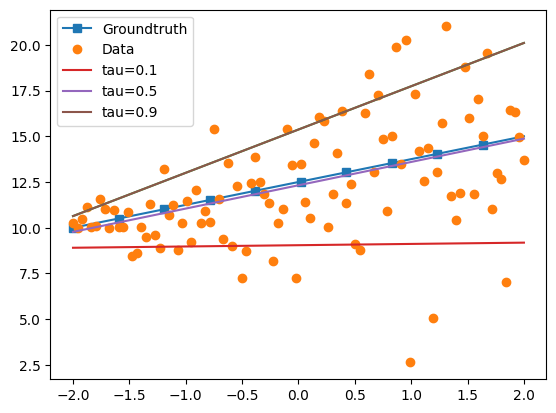

In [43]:
from scipy.optimize import fmin_l_bfgs_b

lbda = 0.01
delta = 0.5

def pobj_l2(params, X=X, y=y, lbda=lbda, tau=tau, delta=delta):
    """Objective function with L2 penalty."""
    w = params[1:]
    b = params[0]
    residual = y - np.dot(X, w) -b
    return np.mean(smooth_pinball(residual, tau=tau, delta=delta)) + lbda * np.sum(w ** 2)

def grad_pobj_l2(params, X=X, y=y, lbda=lbda, tau=tau, delta=delta):
  w = params[1:]
  b = params[0]
  N = X.shape[0]
  residual = y - np.dot(X, w) -b
  grad_w = -(1. / N) * np.dot(X.T, grad_smooth_pinball(residual, tau=tau, delta=delta)) + (2 * lbda) * w
  grad_b = -np.mean(grad_smooth_pinball(residual, tau=tau, delta=delta))
  grad = np.hstack((grad_b, grad_w))
  return grad

def smooth_pinball_lbfgs_l2(X=X, y=y, lbda=lbda, tau=tau, delta=delta):
    """Estimate w and b using L-BFGS.
    
    Parameters
    ----------
    X : ndarray, shape (n_samples, n_features)
        The array of features.
    y : ndarray, shape (n_samples,)
        The target.
    lbda : float
        The regularization parameter lbda
    tau : float in [0, 1]
        The quantile.
    delta : float
        The smoothing parameter.
    
    Returns
    -------
    w_hat : ndarray, shape (n_features,)
        The estimated w.
    b_hat : float
        The estimated b.
    """
    # TODO
    
    # Initialize the variables to optimize
    x_init = np.zeros(X.shape[1]+1)

    # Define the loss and gradient functions to use in the optimization
    loss = pobj_l2
    grad = grad_pobj_l2

    # Run the L-BFGS optimization algorithm to minimize the objective function
    x_min, f_min, _ = fmin_l_bfgs_b(loss, x_init, grad, args=(X, y, lbda, tau, delta), pgtol=1e-30, factr=1e-30)

    # Extract the optimal values of w and b
    w_hat = x_min[1:]
    b_hat = x_min[0]
    
    # END TODO
    return w_hat, b_hat


w_hat, b_hat = smooth_pinball_lbfgs_l2(X, y, lbda=0.01, tau=0.9, delta=0.5)
y_pred = np.dot(X, w_hat) + b_hat


# TODO  (visualization of the fit)
plt.plot(x, y_true, "s-", label='Groundtruth', markevery=10)
plt.plot(x, y, 'o', label="Data")
plt.plot(x, y_pred)

for tau in [0.1, 0.5, 0.9] :
  w_hat, b_hat = smooth_pinball_lbfgs_l2(X, y, lbda=0.01, tau=tau, delta=0.5)
  y_pred = np.dot(X, w_hat) + b_hat
  plt.plot(x, y_pred, label=f"tau={tau}")

plt.legend()

# END TODO

## Part 2: Smooth quantile regression with L1 regularization

In this section we are interested in the $\ell_1$ regularized model.
To help you we give you the code of the objective function to minimize.

In [44]:
def pobj_l1(params, X=X, y=y, lbda=lbda, tau=tau, delta=delta):
    w = params[1:]
    b = params[0]
    return np.mean(smooth_pinball(y - np.dot(X, w) - b, tau=tau, delta=delta)) + lbda * np.sum(np.abs(w))

Now that we have the cost function, you are going to implement solvers based on:

- Proximal Gradient Descent (PGD aka ISTA)
- Accelerated Proximal Gradient Descent (APGD aka FISTA)
- Proximal Coordinate Descent (PCD)

Before this we are going to define the `monitor` class previously used in the second lab as well as plotting functions useful to monitor convergence.

In [45]:
class monitor(object):
    def __init__(self, algo, obj, x_min, args=()):
        self.x_min = x_min
        self.algo = algo
        self.obj = obj
        self.args = args
        if self.x_min is not None:
            self.f_min = obj(x_min, *args)

    def run(self, *algo_args, **algo_kwargs):
        t0 = time.time()
        _, x_list = self.algo(*algo_args, **algo_kwargs)
        self.total_time = time.time() - t0
        self.x_list = x_list
        if self.x_min is not None:
            self.err = [linalg.norm(x - self.x_min) for x in x_list]
            self.obj = [self.obj(x, *self.args) - self.f_min for x in x_list]
        else:
            self.obj = [self.obj(x, *self.args) for x in x_list]


def plot_epochs(monitors, solvers,title = ""):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle(title) 
    
    for monit in monitors:
        ax1.semilogy(monit.obj, lw=2)
        ax1.set_title("Objective")
        ax1.set_xlabel("Epoch")
        if monit.x_min is None:
            ax1.set_ylabel("$f(x_k)$")
        else:
            ax1.set_ylabel("$f(x_k) - f(x^*)$")

    ax1.legend(solvers)

    for monit in monitors:
        if monit.x_min is not None:
            ax2.semilogy(monit.err, lw=2)
            ax2.set_title("Distance to optimum")
            ax2.set_xlabel("Epoch")
            ax2.set_ylabel("$\|x_k - x^*\|_2$")

    ax2.legend(solvers)


def plot_time(monitors, solvers):
    for monit in monitors:
        objs = monit.obj
        plt.semilogy(np.linspace(0, monit.total_time, len(objs)), objs, lw=2)
        plt.title("Loss")
        plt.xlabel("Timing")
        plt.ylabel("$f(x_k) - f(x^*)$")

    plt.legend(solvers)

#### QUESTION 7a:
- Implement the proximal gradient descent (PGD) method.

**Note:**  The parameter `step` is the size of the gradient step that you will need to propose by computing the Lipschitz constant of the data fitting term (Smooth pinball term without regularization term).

In [46]:
def pgd(x_init, grad, prox, step, n_iter=100, store_every=1,
        grad_args=(), prox_args=()):
    """Proximal gradient descent algorithm.
    
    Parameters
    ----------
    x_init : array, shape (n_parameters,)
        Parameters of the optimization problem.
    grad : callable
        The gradient of the smooth data fitting term.
    prox : callable
        The proximal operator of the regularization term.
    step : float
        The size of the gradient step done on the smooth term.
    n_iter : int
        The number of iterations.
    store_every : int
        At which frequency should the current iterated be remembered.
    grad_args : tuple
        Parameters to pass to grad.
    prox_args : tuple
        Parameters to pass to prox.
    
    Returns
    -------
    x : array, shape (n_parameters,)
        The estimated parameters.
    x_list : list
        The list if x values along the iterations.
    """
    x = x_init.copy()
    x_list = []
    for i in range(n_iter):
        ### TODO
        x = prox(x - (grad(x, grad_args[0], grad_args[1], grad_args[2], grad_args[3])/step),1/step, prox_args[0])
        ### END TODO
        if i % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

#### QUESTION 7b:</b>
- Implement the L1 and L2 proximal operators. You will pay attention to the intercept.
- Using the monitor class and the plot_epochs function, display the convergence.

In order to get a good value of `x_min` you will let your PGD solver run for 10000 iterations.

First you will need to implement the proximal operator functions for $\ell_1$ and $\ell_2$ regularized models.

In [47]:
from numpy.linalg import norm
## TODO
def prox_R2(params, reg=1.):
    w = params[1:] / (1 + 2* reg)
    params[1:] = w.copy()
    return params

def prox_R1(params, reg=1.):
    w = np.sign(params[1:]) * np.maximum(np.abs(params[1:])-reg,0)
    params[1:] = w.copy()
    return params

def prox_l2(params, step, lbda):
    return prox_R2(params, reg=step * lbda)

def prox_l1(params, step, lbda):
    return prox_R1(params, reg=step * lbda)

##END TODO

In [48]:
# Generate bigger data
from sklearn.datasets import make_regression

X, y = make_regression(n_samples=500, n_features=100, random_state=0,
                       noise=4.0, bias=10.0)
n_samples, n_features = X.shape

# Set initial values of parameters to optimize
x_init = np.zeros(n_features + 1)
x_init[0] = np.mean(y)
n_iter = 10_000
lbda = 1
delta = 0.5
tau = 0.5

# TODO (implement function grad_smooth_pinball_loss and define step)
def grad_smooth_pinball_loss(params, X, y, tau, delta):
    """Compute the gradient of the smooth pinball loss function.
    
    Parameters
    ----------
    params : ndarray, shape (n_features + 1,)
        The model parameters. The last element is the bias term.
    X : ndarray, shape (n_samples, n_features)
        The features.
    y : ndarray, shape (n_samples,)
        The target.
    tau : float
        The quantile.        
    Returns
    -------
    grad : ndarray, shape (n_features + 1,)
        The gradient of the smooth pinball loss function.
    """
    
    # Split the parameters into the weight and bias terms.
    w = params[1:]
    b = params[0]
    
    # Calculate the number of samples.
    N = X.shape[0]
    
    # Calculate the residuals.
    residual = y - np.dot(X, w) - b
    
    # Calculate the gradient of the smooth pinball loss with respect to the weight and bias terms.
    grad_w = -(1. / N) * np.dot(X.T, grad_smooth_pinball(residual, tau=tau, delta=delta))
    grad_b = -np.mean(grad_smooth_pinball(residual, tau=tau, delta=delta))
    
    # Stack the gradient of the weight and bias terms into a single array.
    grad = np.hstack((grad_b, grad_w))
    
    return grad


def step_funct(X, delta):
  n = X.shape[0]
  return (norm(X, ord=2)**2 )/ (delta * n)

step = step_funct(X, delta)

# END TODO

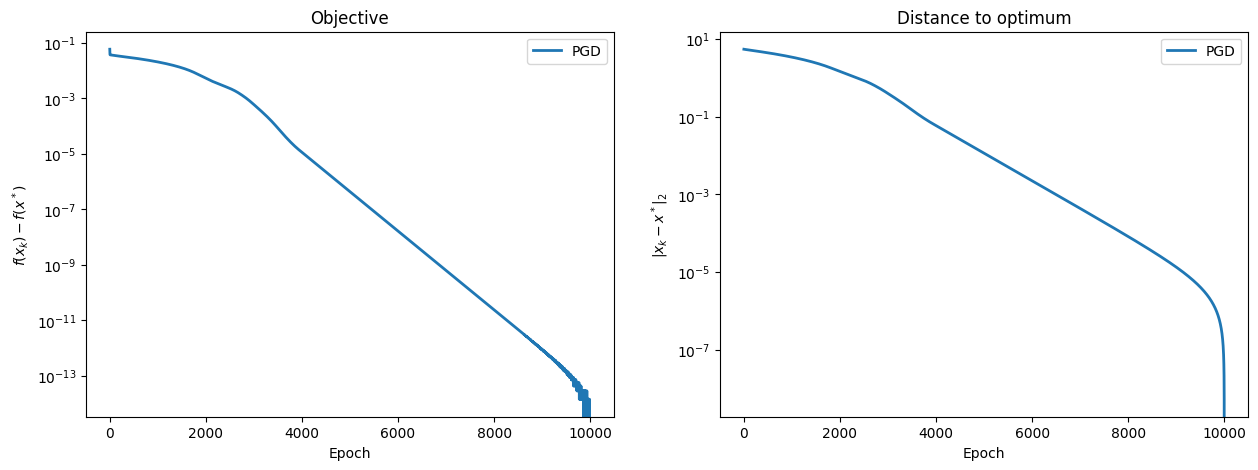

In [49]:
# Get a good x_min by letting the algorithm converge with many iterations
x_min, _ = pgd(x_init, grad_smooth_pinball_loss, prox_l2, step, n_iter=10000, store_every=1000,
               grad_args=(X, y, tau, delta), prox_args=(lbda,))

# Run PGD
monitor_pgd_l2 = monitor(pgd, pobj_l2, x_min, args=(X, y, lbda, tau, delta))
monitor_pgd_l2.run(x_init, grad_smooth_pinball_loss, prox_l2, step, n_iter,
                   grad_args=(X, y, tau, delta), prox_args=(lbda,))

monitors = [monitor_pgd_l2]
solvers = ["PGD"]
plot_epochs(monitors, solvers)

Now for the $\ell_1$ regularization:

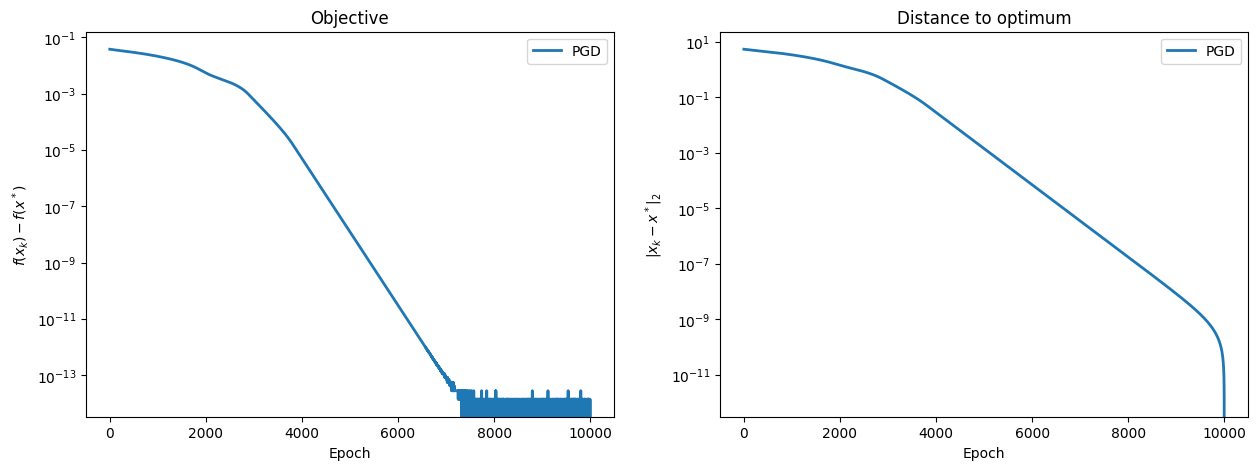

In [50]:
# Run PGD for L1
x_min_l1, _ = pgd(x_init, grad_smooth_pinball_loss, prox_l1, step, n_iter=10000, store_every=1000,
               grad_args=(X, y, tau, delta), prox_args=(lbda,))
monitor_pgd_l1 = monitor(pgd, pobj_l1, x_min=x_min_l1, args=(X, y, lbda, tau, delta))
monitor_pgd_l1.run(x_init, grad_smooth_pinball_loss, prox_l1, step, n_iter,
                   grad_args=(X, y, tau, delta), prox_args=(lbda,))

monitors = [monitor_pgd_l1]
solvers = ["PGD"]
plot_epochs(monitors, solvers)

QUESTION 8:
- Implement the accelerated proximal gradient descent (APGD) and add this solver to the monitoring plots.

In [51]:
def apgd(x_init, grad, prox, step, n_iter=100, store_every=1,
         grad_args=(), prox_args=()):
    """Accelerated proximal gradient descent algorithm."""
    x = x_init.copy()
    x_new = x_init.copy()
    z = x_init.copy()
    t = 1.
    t_new = 1.
    x_list = []
    
    for i in range(n_iter):
        
        # Compute the proximal update
        x_new = prox(z - (grad(z, grad_args[0], grad_args[1], grad_args[2], grad_args[3]) / step), 
                     1/step, prox_args[0])
        # Update the momentum parameter
        t_new = (1 + np.sqrt(1 + 4*(t**2)))/2
        # Update the intermediate solution
        z = x_new +  ((t - 1) / t_new) * (x_new - x) 
        # Update the current solution
        x = x_new
        # Update the momentum parameter
        t = t_new

        if i % store_every == 0:
            x_list.append(x.copy())
    return x, x_list


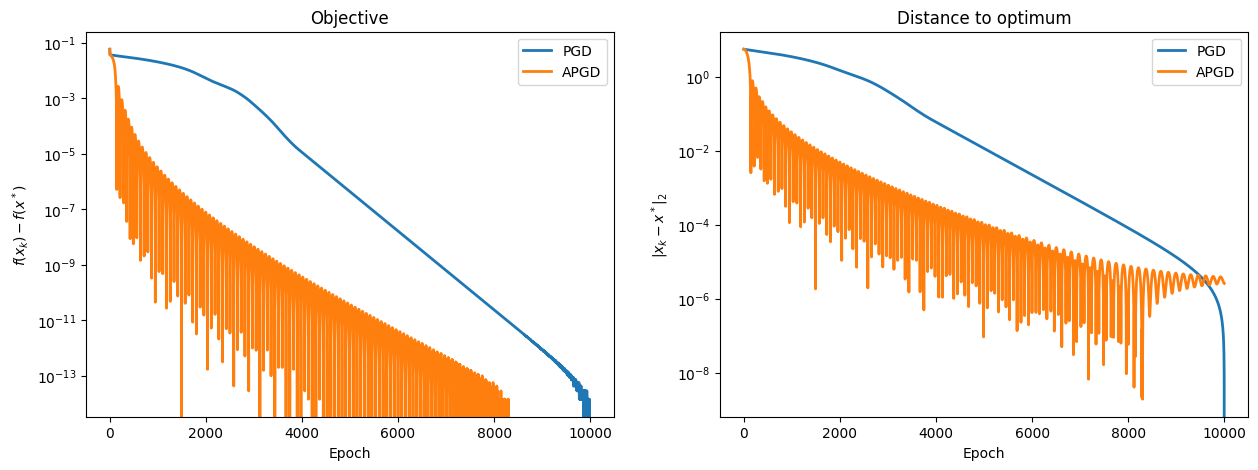

In [52]:
# TODO
monitor_apgd_l2 = monitor(apgd, pobj_l2, x_min, args=(X, y, lbda, tau, delta))
monitor_apgd_l2.run(x_init, grad_smooth_pinball_loss, prox_l2, step, n_iter,
                   grad_args=(X, y, tau, delta), prox_args=(lbda,))
# END TODO

monitors = [monitor_pgd_l2, monitor_apgd_l2]
solvers = ["PGD", "APGD"]
plot_epochs(monitors, solvers)

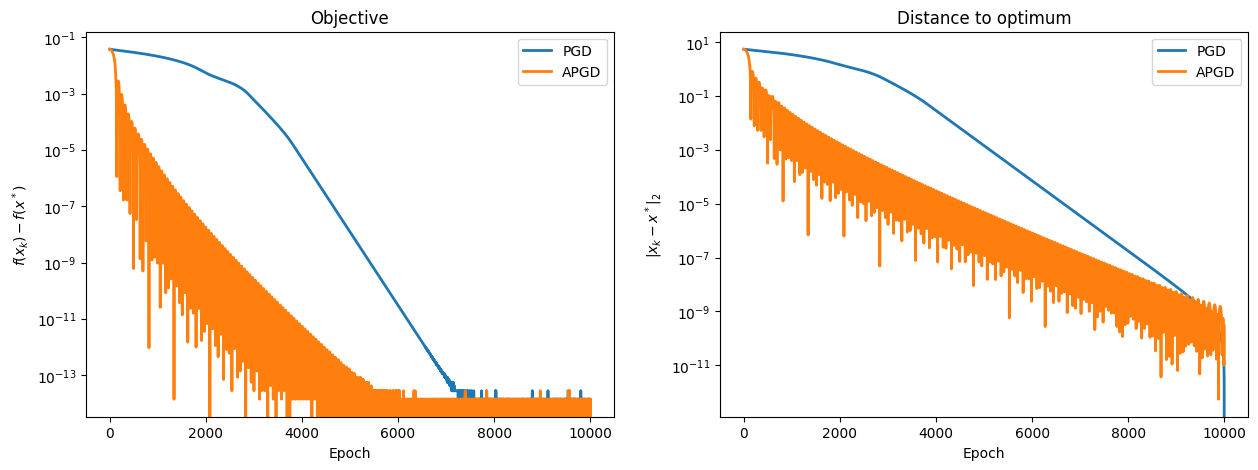

In [53]:
# TODO
monitor_apgd_l1 = monitor(apgd, pobj_l1, x_min=x_min_l1, args=(X, y, lbda, tau, delta))
monitor_apgd_l1.run(x_init, grad_smooth_pinball_loss, prox_l1, step, n_iter,
                   grad_args=(X, y, tau, delta), prox_args=(lbda,))
# END TODO

monitors = [monitor_pgd_l1, monitor_apgd_l1]
solvers = ["PGD", "APGD"]
plot_epochs(monitors, solvers)

#### QUESTION 9
- Implement the proximal coordinate descent (PCD) and add this solver to the monitoring plots for L1 and L2 regularized models.

**Note:** You are welcome to try to use numba to get reasonable performance but don't spend too much time if you get weird numba errors.

In [54]:
#Implement the proximal coordinate descent (PCD) 
def pcd(x_init, grad, prox, step, n_iter=100, store_every=1,grad_args=(), prox_args=()):
    n_samples, n_features = X.shape
    x = x_init.copy()
    x_list = []
  

    for t in range(n_iter):
        #for j in range(n_features):
        j = t % n_features         
        x[[0,j+1]] = prox(x[[0,j+1]] - step * grad(x, *grad_args)[[0,j+1]], step, *prox_args)  
        if t % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

In [55]:
""" 
#Implement the proximal coordinate descent (PCD) 
def pcd(x_init, grad, prox, step, n_iter=100, store_every=1,grad_args=(), prox_args=()):
    n_samples, n_features = X.shape
    x = x_init.copy()
    x_list = []
    
    step = np.sum(X * X, axis=0) / (delta * n_features)

    for t in range(n_iter):
        #for j in range(n_features):
        j = t % n_features     
        x[[0,j+1]] = prox(x[[0,j+1]] - step[j] * grad(x, *grad_args)[[0,j+1]], step[j], *prox_args)  
        if t % store_every == 0:
            x_list.append(x.copy())
    return x, x_list
"""

' \n#Implement the proximal coordinate descent (PCD) \ndef pcd(x_init, grad, prox, step, n_iter=100, store_every=1,grad_args=(), prox_args=()):\n    n_samples, n_features = X.shape\n    x = x_init.copy()\n    x_list = []\n    \n    step = np.sum(X * X, axis=0) / (delta * n_features)\n\n    for t in range(n_iter):\n        #for j in range(n_features):\n        j = t % n_features     \n        x[[0,j+1]] = prox(x[[0,j+1]] - step[j] * grad(x, *grad_args)[[0,j+1]], step[j], *prox_args)  \n        if t % store_every == 0:\n            x_list.append(x.copy())\n    return x, x_list\n'

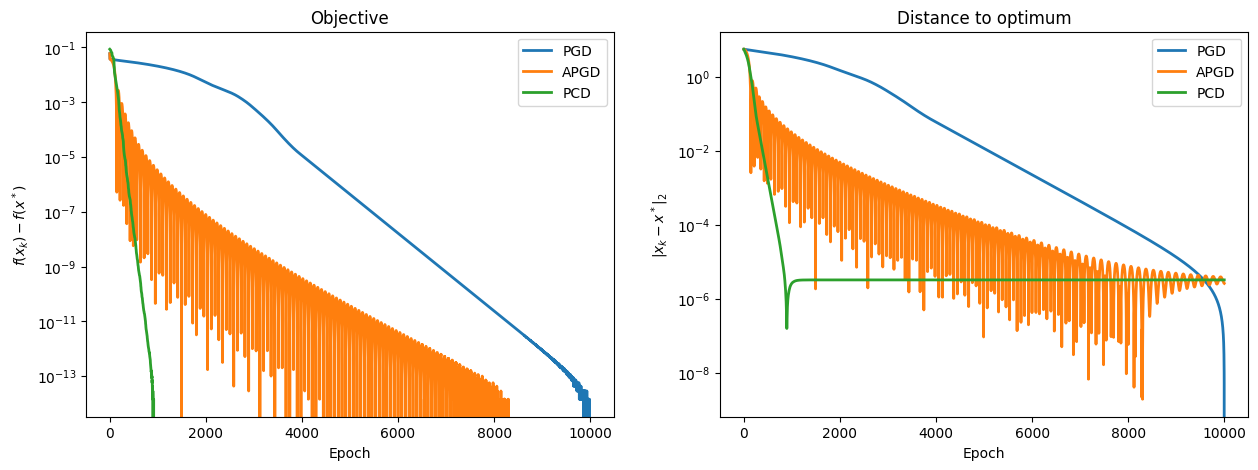

In [56]:
#TODO
monitor_pcd_l2 = monitor(pcd, pobj_l2, x_min, args=(X, y, lbda, tau, delta))
monitor_pcd_l2.run(x_init, grad_smooth_pinball_loss, prox_l2, step, n_iter,
                   grad_args=(X, y, tau, delta), prox_args=(lbda,))
# END TODO

monitors = [monitor_pgd_l2, monitor_apgd_l2,monitor_pcd_l2]
solvers = ["PGD","APGD","PCD"]
plot_epochs(monitors, solvers)

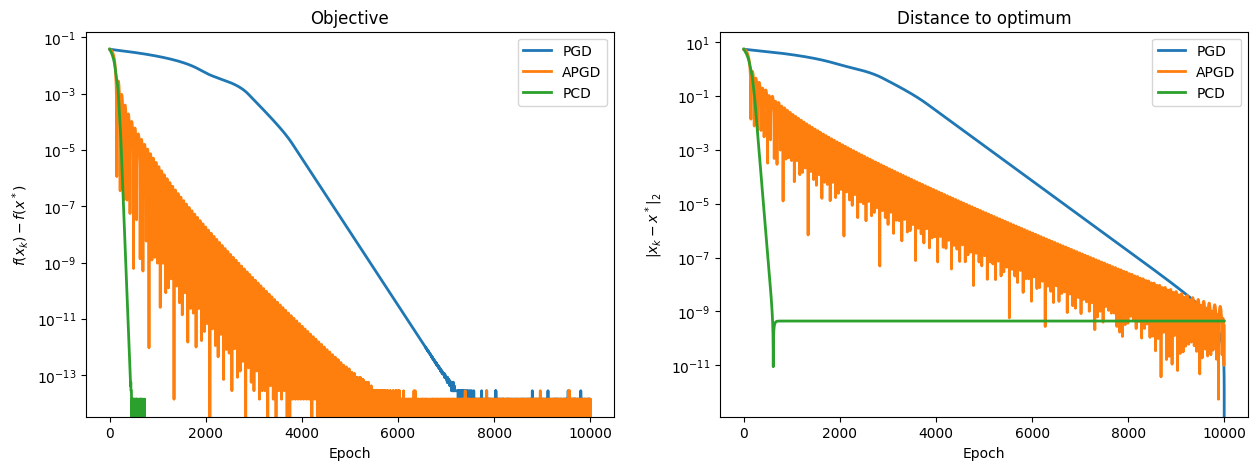

In [57]:
# TODO
monitor_pcd_l1 = monitor(pcd, pobj_l1, x_min=x_min_l1, args=(X, y, lbda, tau, delta))
monitor_pcd_l1.run(x_init, grad_smooth_pinball_loss, prox_l1, step, n_iter,
                   grad_args=(X, y, tau, delta), prox_args=(lbda,))
# END TODO

monitors = [monitor_pgd_l1, monitor_apgd_l1,monitor_pcd_l1]
solvers = ["PGD", "APGD","PCD"]
plot_epochs(monitors, solvers)

#### QUESTION 10
- Compare the performance of the different solvers for different (simulated) problem sizes. You will test on a dataset with n_samples >> n_features, n_samples << n_features, and for high and low values of $\lambda$.
- What solver would you recommend for each of the 4 scenarios?

**Remark:** What is expected from you here is to provide clear and synthetic plots that show the performance of the different solvers for the different simulated datasets.

In [58]:
from sklearn.datasets import make_regression

def test_performance(n_samples=1000,n_features=100,penality="l2",title="") :
    
    X, y = make_regression(n_samples, n_features, random_state=0,noise=4.0, bias=10.0)
    n_samples, n_features = X.shape

    # Set initial values of parameters to optimize
    x_init = np.zeros(n_features + 1)
    
    for lbda in [0.01,1.] : 
        if penality == "l2" : 
            # Get a good x_min by letting the algorithm converge with many iterations
            x_min, _ = pgd(x_init, grad_smooth_pinball_loss, prox_l2, step, n_iter=10000, store_every=1000,
                        grad_args=(X, y, tau, delta), prox_args=(lbda,))
            
            # Run PGD
            monitor_pgd= monitor(pgd, pobj_l2, x_min, args=(X, y, lbda, tau, delta))
            monitor_pgd.run(x_init, grad_smooth_pinball_loss, prox_l2, step, n_iter,
                            grad_args=(X, y, tau, delta), prox_args=(lbda,))
            # Run APGD
            monitor_apgd = monitor(apgd, pobj_l2, x_min, args=(X, y, lbda, tau, delta))
            monitor_apgd.run(x_init, grad_smooth_pinball_loss, prox_l2, step, n_iter,
                            grad_args=(X, y, tau, delta), prox_args=(lbda,))
            #Run PCD 
            monitor_pcd = monitor(pcd, pobj_l2, x_min, args=(X, y, lbda, tau, delta))
            monitor_pcd.run(x_init, grad_smooth_pinball_loss, prox_l2, step, n_iter,
                            grad_args=(X, y, tau, delta), prox_args=(lbda,))
            
        else : 
            x_min, _ = pgd(x_init, grad_smooth_pinball_loss, prox_l1, step, n_iter=10000, store_every=1000,
                        grad_args=(X, y, tau, delta), prox_args=(lbda,))
            
            # Run PGD
            monitor_pgd = monitor(pgd, pobj_l1, x_min, args=(X, y, lbda, tau, delta))
            monitor_pgd.run(x_init, grad_smooth_pinball_loss, prox_l1, step, n_iter,
                            grad_args=(X, y, tau, delta), prox_args=(lbda,))
            # Run APGD
            monitor_apgd = monitor(apgd, pobj_l1, x_min, args=(X, y, lbda, tau, delta))
            monitor_apgd.run(x_init, grad_smooth_pinball_loss, prox_l1, step, n_iter,
                            grad_args=(X, y, tau, delta), prox_args=(lbda,))
            #Run PCD 
            monitor_pcd = monitor(pcd, pobj_l1, x_min, args=(X, y, lbda, tau, delta))
            monitor_pcd.run(x_init, grad_smooth_pinball_loss, prox_l1, step, n_iter,
                            grad_args=(X, y, tau, delta), prox_args=(lbda,))
            
            # PLOT
            monitors = [monitor_pgd, monitor_apgd,monitor_pcd]
            solvers = ["PGD","APGD","PCD"]
            plot_epochs(monitors, solvers,title+"lambda = " + str(lbda))
        

# L1

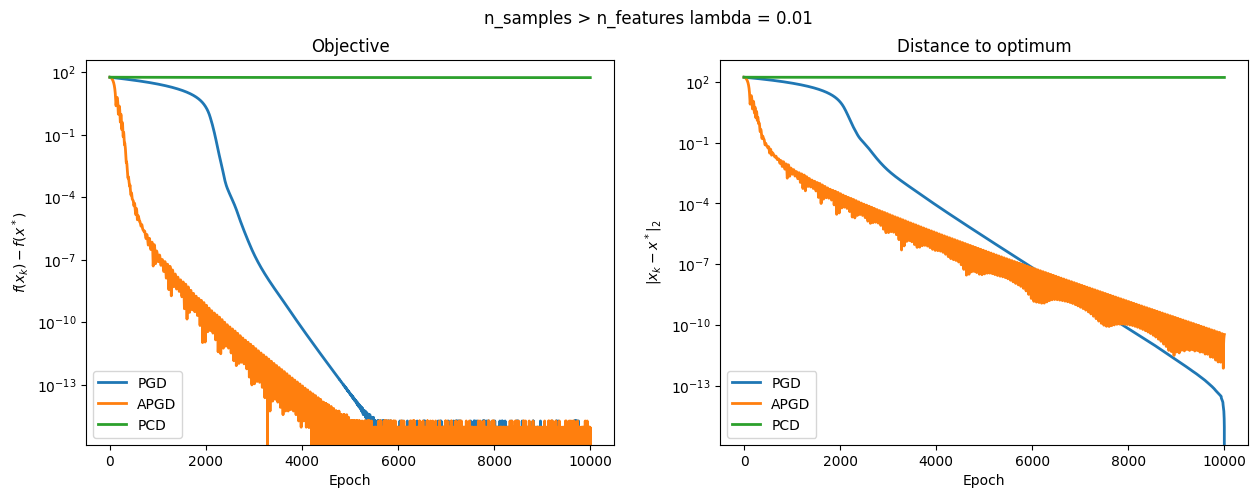

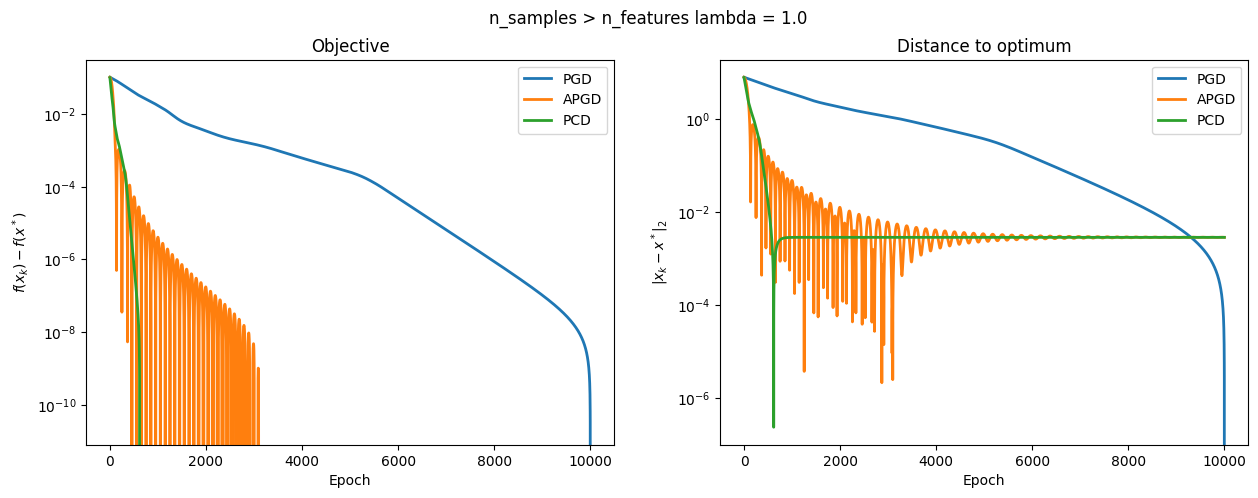

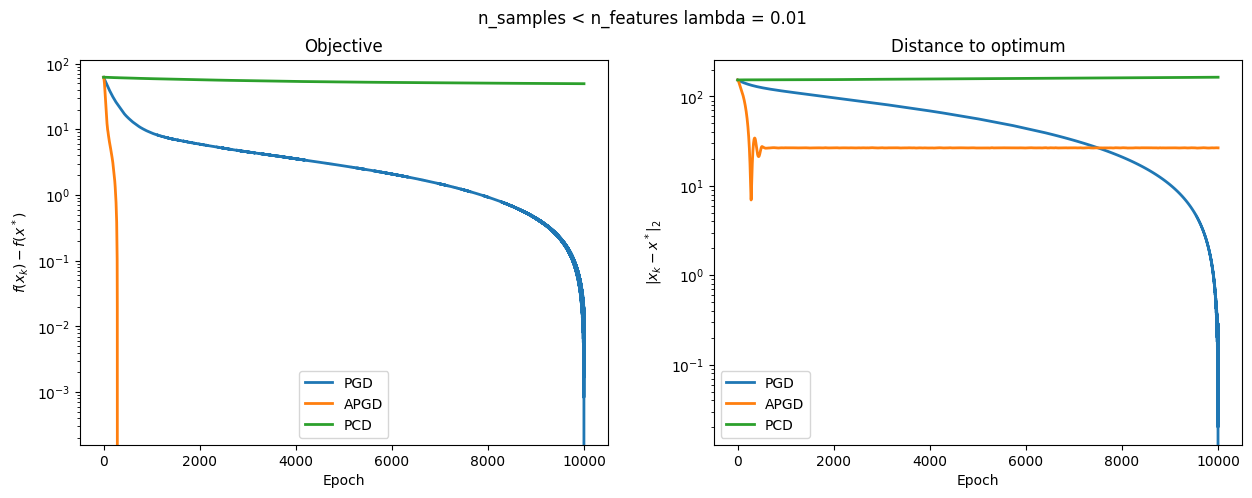

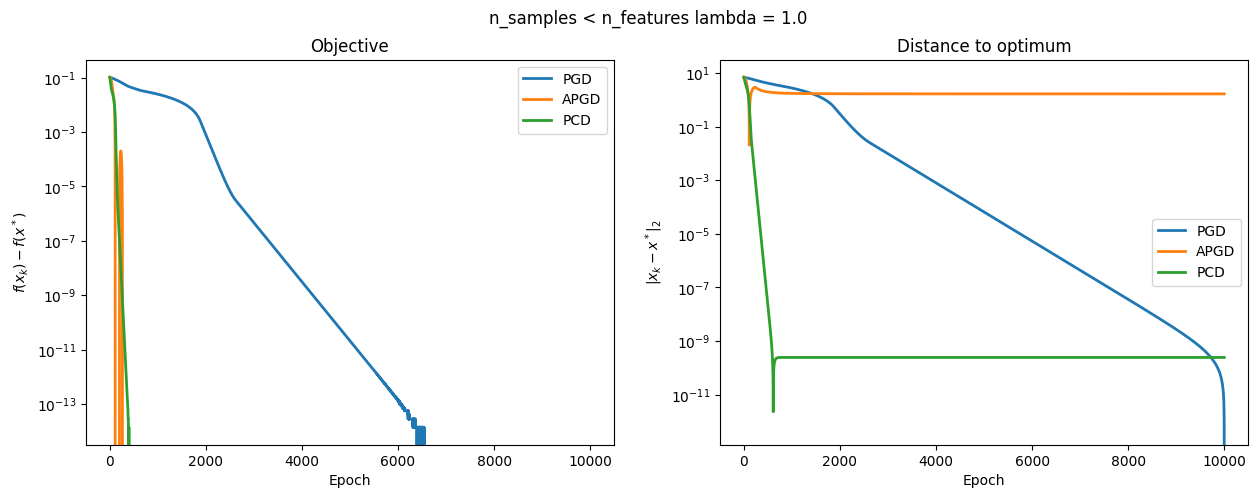

In [59]:
test_performance(1000,200,"l1","n_samples > n_features ")
test_performance(200,1000,"l1","n_samples < n_features ")

# L2

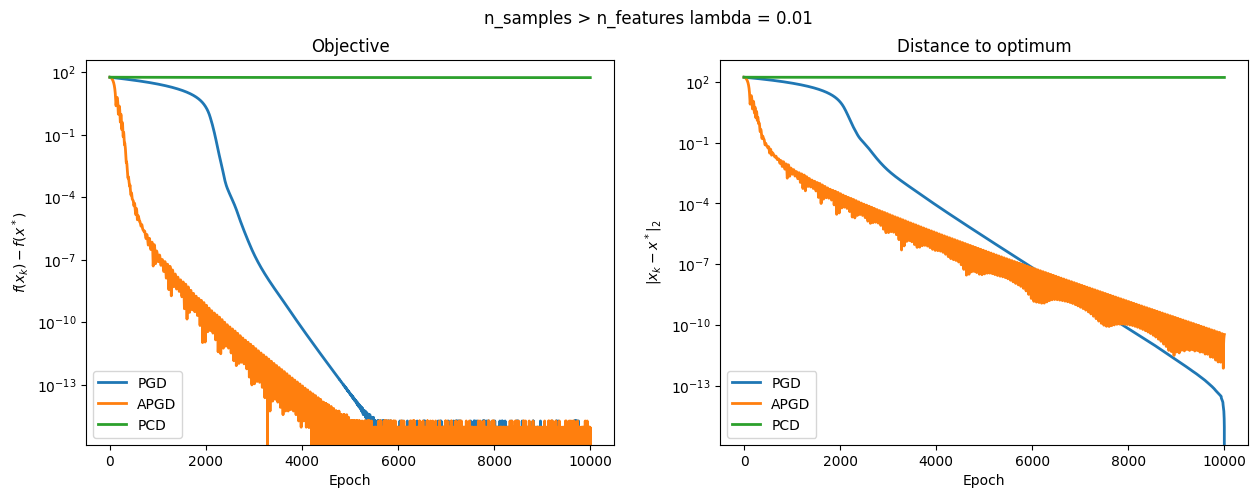

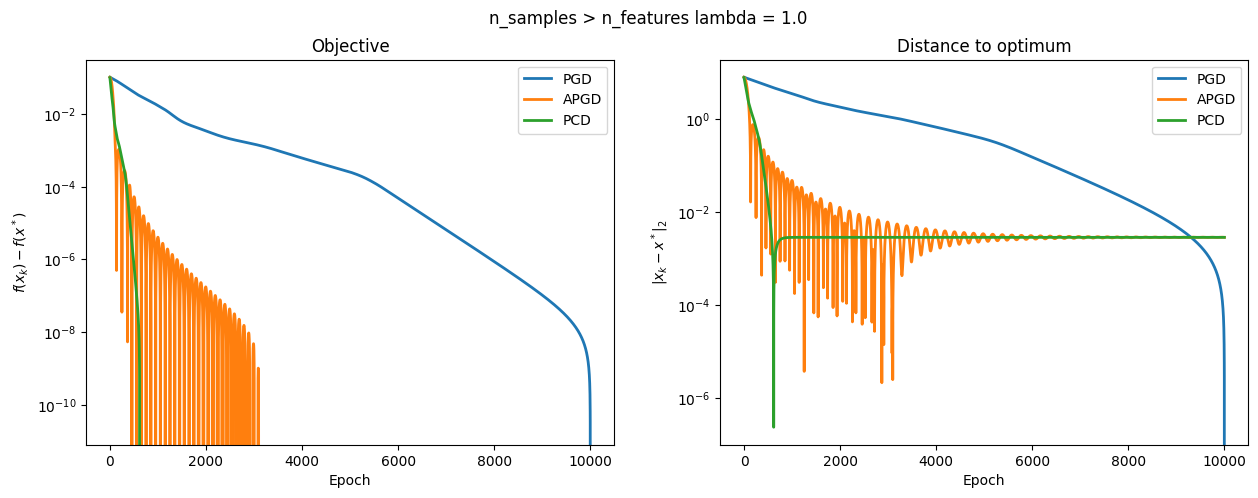

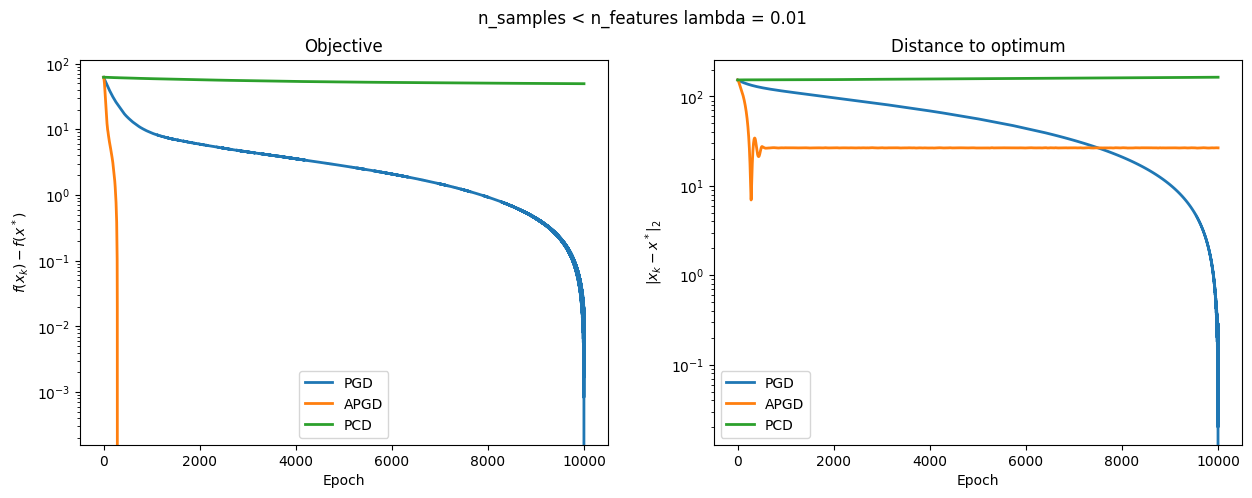

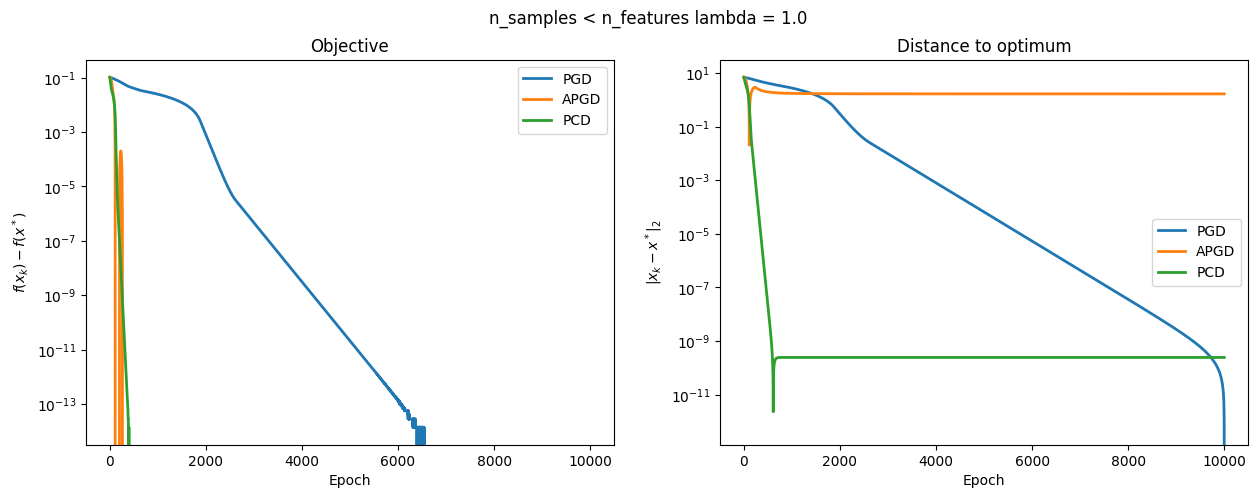

In [60]:
test_performance(1000,200,"l1","n_samples > n_features ")
test_performance(200,1000,"l1","n_samples < n_features ")

# Part 3: Application

You will now apply your solver to some census dataset where we aim to predict the wage of a person give some demographic and work related variables.

**Disclaimer:** This dataset is not huge and regularization makes little sense with so little features but it serves as a simple illustration.

Let's first inspect the dataset:

In [61]:
from sklearn.datasets import fetch_openml
wages = fetch_openml(name="cps_85_wages", as_frame=True)
X_df, y_df = wages["data"], wages["target"]
X_df.head()

,EDUCATION,SOUTH,SEX,EXPERIENCE,UNION,AGE,RACE,OCCUPATION,SECTOR,MARR
0,8.0,no,female,21.0,not_member,35.0,Hispanic,Other,Manufacturing,Married
1,9.0,no,female,42.0,not_member,57.0,White,Other,Manufacturing,Married
2,12.0,no,male,1.0,not_member,19.0,White,Other,Manufacturing,Unmarried
3,12.0,no,male,4.0,not_member,22.0,White,Other,Other,Unmarried
4,12.0,no,male,17.0,not_member,35.0,White,Other,Other,Married


(array([138., 208., 119.,  35.,  22.,  11.,   0.,   0.,   0.,   1.]),
 array([ 1.  ,  5.35,  9.7 , 14.05, 18.4 , 22.75, 27.1 , 31.45, 35.8 ,
        40.15, 44.5 ]),
 <BarContainer object of 10 artists>)

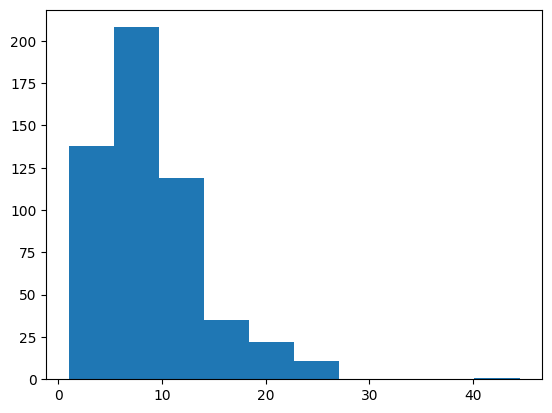

In [62]:
plt.hist(y_df)

In [63]:
X_df.dtypes

EDUCATION      float64
SOUTH         category
SEX           category
EXPERIENCE     float64
UNION         category
AGE            float64
RACE          category
OCCUPATION    category
SECTOR        category
MARR          category
dtype: object

Now let's extract `X` taking only the numerical columns (y is already defined above) and do some basic plot:

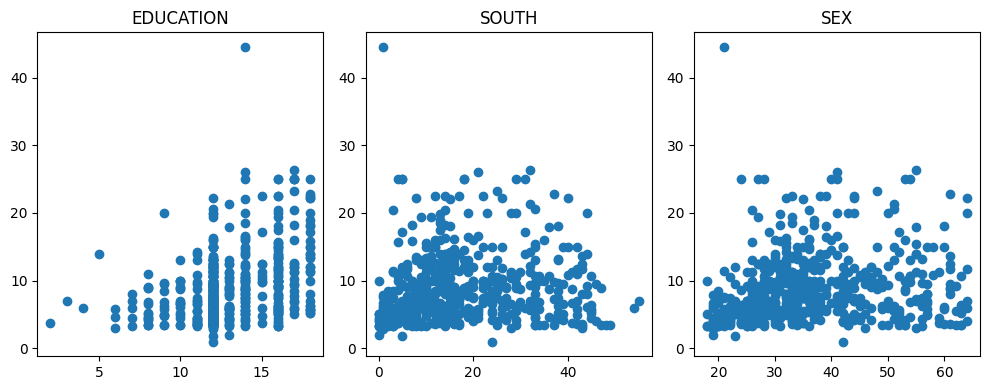

In [64]:
X_df_num = X_df.select_dtypes(include=(float, int))

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 4))
for x, col_name, ax in zip(X_df_num.values.T, X_df.columns, axes.ravel()):
    ax.plot(x, y_df, 'o')
    ax.set_title(col_name)
fig.tight_layout()

In [65]:
X = X_df_num.values
y = y_df.values
y.shape, X.shape

((534,), (534, 3))

We have now X and y!

In order to facilitate our experiment we're going to write a full scikit-learn estimator.

#### QUESTION 11
- Implement the `fit` method from the estimator in the next cell and fit the model with the different solvers you implemented above.

In [66]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.preprocessing import scale

class SmoothQuantileRegressor(BaseEstimator, RegressorMixin):
    """scikit-learn estimator for regression with a smoothed quantile loss.
    
    Parameters
    ----------
    lbda : float
        The regularization parameter
    penalty : 'l1' | 'l2'
        The type of regularization to use.
    tau : float in (0, 1)
        The quantile to predict.
    delta : float
        The smoothing parameter.
    max_iter : int
        The number of iterations / epochs to do on the data.
    solver : 'pgd' | 'apgd' | 'pcd'
        The type of algorithm to use.
        
    Attributes
    ----------
    coef_ : ndarray, (n_features,)
        The weitghs w.
    intercept_ : float
        The intercept or bias term b.
    """
    def __init__(self, lbda=1., penalty='l2', tau=0.5, delta=0.5,
                 max_iter=2000, solver='pgd'):
        self.lbda = lbda
        self.penalty = penalty
        self.tau = tau
        self.delta = delta
        self.max_iter = max_iter
        self.solver = solver
        assert self.penalty in ['l1', 'l2']
        assert self.solver in ['pgd', 'apgd', 'pcd'] 

    def fit(self, X, y):
        """Fit method
        
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The features.
        y : ndarray, shape (n_samples,)
            The target.
        """
        n_samples, n_features = X.shape
        # TODO
        x_init = np.zeros(n_features + 1)
        #x_init[0] = np.mean(y)
                        
        if (self.penalty=="l1"):
            mtor = monitor(eval(self.solver), pobj_l1, x_min=None, args=(X, y, self.lbda, self.tau, self.delta))
            mtor.run(x_init, grad_smooth_pinball_loss, prox_l1, step, self.max_iter,grad_args=(X, y, self.tau, self.delta), prox_args=(self.lbda,))
        else:
            mtor = monitor(eval(self.solver), pobj_l2, x_min=None, args=(X, y, self.lbda, self.tau, self.delta))
            mtor.run(x_init, grad_smooth_pinball_loss, prox_l2, step, self.max_iter,grad_args=(X, y, self.tau, self.delta), prox_args=(self.lbda,))
        
        x = mtor.x_list[-1]                         

        # END TODO
        self.params_ = x
        self.coef_ = x[1:]
        self.intercept_ = x[0]
        return self


    def predict(self, X):
        """Predict method
        
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The features.

        Returns
        -------
        y_pred : ndarray, shape (n_samples,)
            The predicted target.
        """
        return np.dot(X, self.coef_) + self.intercept_

    
    def score(self, X, y):
        """Score using the pinball loss.
        
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The features.
        y : ndarray, shape (n_samples,)
            The target.
            
        Returns
        -------
        score : float
            The negative pinball loss.
            Negative to keep the semantic that higher is better.
        """
        return -np.mean(pinball(y - self.predict(X), tau=self.tau))

lbda = 1e-4
max_iter = 1000

X_scaled = scale(X)  # standardize the features

for solver in ['pgd', 'apgd', 'pcd']:
    clf = SmoothQuantileRegressor(lbda=lbda, penalty='l2', max_iter=max_iter, solver=solver)
    clf.fit(X_scaled, y)
    print('Solver with L2: %s   \t-   Pinball : %.5f' % (solver, -clf.score(X, y)))

for solver in ['pgd', 'apgd', 'pcd']:
    clf = SmoothQuantileRegressor(lbda=lbda, penalty='l1', max_iter=max_iter, solver=solver)
    clf.fit(X_scaled, y)
    print('Solver with L1: %s   \t-   Pinball : %.5f' % (solver, -clf.score(X, y)))

Solver with L2: pgd   	-   Pinball : 34.64638
Solver with L2: apgd   	-   Pinball : 29.35055
Solver with L2: pcd   	-   Pinball : 32.46917
Solver with L1: pgd   	-   Pinball : 34.70558
Solver with L1: apgd   	-   Pinball : 16.04068
Solver with L1: pcd   	-   Pinball : 32.06758


To illustrate the predicitons here is a simple plot where you should see the interval of the predictions with 3 different quantiles. Feel free to comment on what you see and go beyond this plot if you feel inspired !

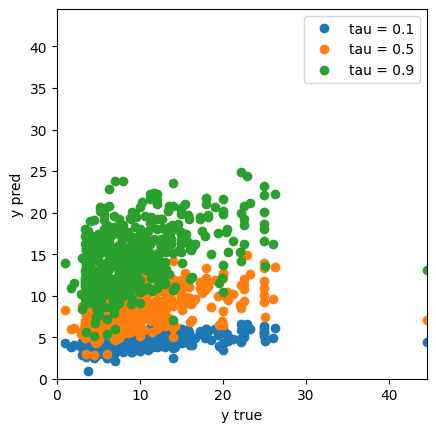

In [67]:
fig, ax = plt.subplots()
for tau in [0.1, 0.5, 0.9]:
    clf = SmoothQuantileRegressor(lbda=lbda, penalty='l1', solver="apgd", tau=tau)
    y_pred = clf.fit(X_scaled, y).predict(X_scaled)
    ax.plot(y, y_pred, 'o', label=f'tau = {tau:.1f}')
    ax.axis("square")

ax.set(xlabel="y true", ylabel="y pred", xlim=(0, np.max(y)), ylim=(0, np.max(y)))
plt.legend();

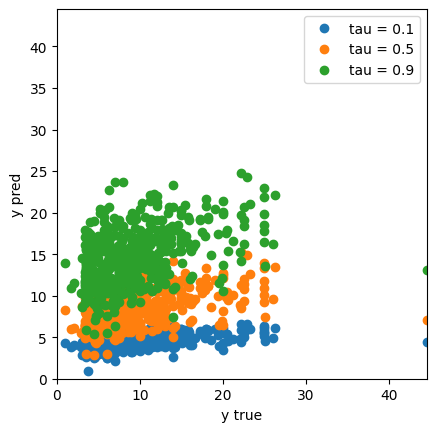

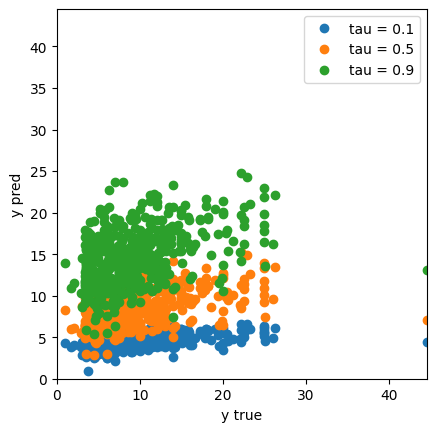

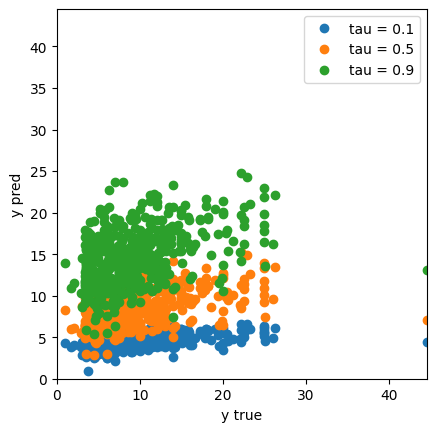

In [68]:
#pour test
for x in ["pgd","apgd","pcd"] : 
    fig, ax = plt.subplots()
    for tau in [0.1, 0.5, 0.9]:
        clf = SmoothQuantileRegressor(lbda=lbda, penalty='l2', solver=x, tau=tau)
        y_pred = clf.fit(X_scaled, y).predict(X_scaled)
        ax.plot(y, y_pred, 'o', label=f'tau = {tau:.1f}')
        ax.axis("square")

    ax.set(xlabel="y true", ylabel="y pred", xlim=(0, np.max(y)), ylim=(0, np.max(y)))
    plt.legend();